# Movie Information ChatBot

## Set-up environment

In [1]:
import os
import pandas as pd

In [2]:
import langdetect
from langdetect import DetectorFactory, detect, detect_langs

In [3]:
from langchain.llms import Ollama
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

In [4]:
# Embedding facilities
from langchain.embeddings import HuggingFaceEmbeddings
# Pipelines
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

## Data Collection

In [5]:
df = pd.read_csv('Data/title.basics.tsv', sep='\t')

C:\Users\Caroline\AppData\Local\Temp\ipykernel_10308\3803222917.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/title.basics.tsv', sep='\t')


In [6]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10790736 entries, 0 to 10790735
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 740.9+ MB


In [16]:
df['titleType'].unique()

array(['short', 'movie', 'tvShort', 'tvMovie', 'tvSeries', 'tvEpisode',
       'tvMiniSeries', 'tvSpecial', 'video', 'videoGame', 'tvPilot'],
      dtype=object)

In [18]:
movie_df = df[df['titleType'].isin(['short', 'movie', 'tvMovie'])]
movie_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,5,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10790676,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama
10790686,tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,0,2013,\N,49,Documentary
10790687,tt9916756,short,Pretty Pretty Black Girl,Pretty Pretty Black Girl,0,2019,\N,\N,Short
10790691,tt9916764,short,38,38,0,2018,\N,\N,Short


In [19]:
title_df = movie_df[['originalTitle']]
title_df

,originalTitle
0,Carmencita
1,Le clown et ses chiens
2,Pauvre Pierrot
3,Un bon bock
4,Blacksmith Scene
...,...
10790676,6 Gunn
10790686,Chico Albuquerque - Revelações
10790687,Pretty Pretty Black Girl
10790691,38


In [20]:
title_df.isnull().sum()

originalTitle    5
dtype: int64

In [23]:
title_df = title_df.dropna()

In [24]:
title_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1823035 entries, 0 to 10790734
Data columns (total 1 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   originalTitle  object
dtypes: object(1)
memory usage: 27.8+ MB


In [25]:
title_df.isnull().sum()

originalTitle    0
dtype: int64

### Load Wikipedia

In [26]:
import loadlib
from loadlib import loadWiki

In [27]:
import importlib 
importlib.reload(loadlib)

<module 'loadlib' from 'C:\\Users\\Caroline\\Documents\\Software-Udvikling\\AI\\AI_exam\\loadlib.py'>

In [28]:
# Collect all here
documents = []

In [29]:
subject = 'Film'

In [30]:
lang = 'en'

In [34]:
docs = loadlib.loadWiki(subject, lang, 2)
documents.extend(docs)

In [35]:
from tqdm import tqdm

In [36]:
titles_to_process = title_df['originalTitle'].iloc[:1000]

In [39]:
for title in tqdm(titles_to_process, desc="Processing titles"):
    docs = loadlib.loadWiki(title, lang, 2)
    documents.extend(docs)

Processing titles:   1%|          | 10/1000 [00:49<1:24:44,  5.14s/it]C:\Users\Caroline\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file C:\Users\Caroline\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')
Processing titles: 100%|██████████| 1000/1000 [1:15:49<00:00,  4.55s/it]


In [40]:
len(documents)

1681

## Chunking

In [41]:
import utils
from utils import chunkDocs, langDetect, wordCloud

In [42]:
import importlib 
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\Caroline\\Documents\\Software-Udvikling\\AI\\AI_exam\\utils.py'>

In [43]:
splits = utils.chunkDocs(documents, 350)  

In [44]:
len(splits)

22127

In [45]:
split_df = pd.DataFrame(splits, columns=['page_content', 'metadata', 'type'])

In [46]:
split_df.sample(3)

,page_content,metadata,type
116,"(page_content, == External links ==\nBlacksmit...","(metadata, {'title': 'Blacksmith Scene', 'summ...","(type, Document)"
15816,"(page_content, Aimée), and two Academy Awards ...","(metadata, {'title': 'A Man and a Woman', 'sum...","(type, Document)"
5699,"(page_content, and 1980s. Between 1983 and 199...","(metadata, {'title': 'Gréco Casadesus', 'summa...","(type, Document)"


## Data Visualisation

In [50]:
im, longstring = utils.wordCloud(split_df, 'page_content')

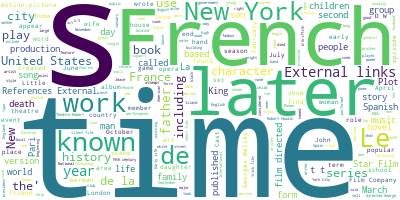

In [51]:
im

## Embeddings

In [52]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

In [57]:
!pip install torchvision --user

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
    --------------------------------------- 0.0/1.2 MB 640.0 kB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.2 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 12.4 MB/s eta 0:00:00


In [58]:
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\Caroline\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [61]:
!pip show torch

Name: torch
Version: 2.3.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: C:\Users\Caroline\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages
Requires: filelock, fsspec, jinja2, mkl, networkx, sympy, typing-extensions
Required-by: sentence-transformers, torchvision
